In [1]:
from skimage.transform import rescale, resize

In [2]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import time

In [5]:
import torch.nn. functional as F

In [6]:
import os

In [7]:
TRAIN_CSV_FILE=pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Dataset/Training/Training_triplets.csv')
VALIDATION_CSV_FILE=pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Dataset/Validation/Validation_triplets.csv')
DATA_DIR="C:/Users/asingh74/Desktop/DML_Projects/FACE/Dataset/Data_Comb/"

In [7]:
BATCH_SIZE=64
LR = 0.0001
EPOCHS = 20
DEVICE  = torch.device('cuda')

In [25]:
train_df=TRAIN_CSV_FILE
valid_df=VALIDATION_CSV_FILE
train_df.head()

Anchor             Positive                  Negative
0  Akshay Kumar_0.jpg   Akshay Kumar_1.jpg     Dwayne Johnson_19.jpg
1  Akshay Kumar_0.jpg  Akshay Kumar_10.jpg      Anushka Sharma_5.jpg
2  Akshay Kumar_0.jpg  Akshay Kumar_11.jpg     Hrithik Roshan_14.jpg
3  Akshay Kumar_0.jpg  Akshay Kumar_12.jpg  Vijay Deverakonda_24.jpg
4  Akshay Kumar_0.jpg  Akshay Kumar_13.jpg          Brad Pitt_18.jpg

In [26]:
row = TRAIN_CSV_FILE.iloc[1]
img = io.imread(DATA_DIR+train_df.iloc[0][0])
img.shape

C:\Users\asingh74\AppData\Local\Temp\ipykernel_27504\596493625.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = io.imread(DATA_DIR+train_df.iloc[0][0])


(256, 256, 3)

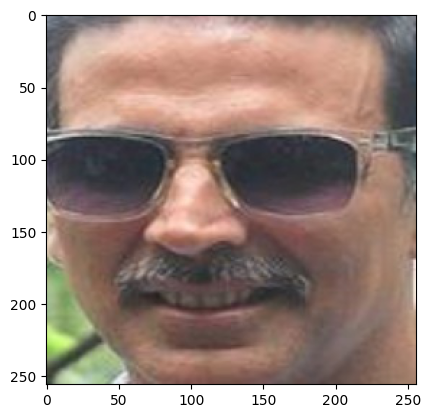

In [27]:
plt.imshow(img)

In [88]:
def std_mm(image, feature_range=(0, 1)):
  image = np.array(image)  # Convert to numpy array
  min_val = np.min(image)
  max_val = np.max(image)
  
  if min_val == max_val:
      return np.ones_like(image) * feature_range[0]  # Return all pixels at min range value
  
  scaled_image = (image - min_val) / (max_val - min_val)
  scaled_image = scaled_image * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_image.astype(image.dtype) 

In [86]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),         
    transforms.RandomHorizontalFlip(p=0.5)                       
])

In [30]:
class APN_Dataset (Dataset):
    
    def __init__(self, df):
        self.df= df
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        A=io.imread(DATA_DIR+str(row.Anchor))
        A=cv2.resize(A, (224, 224))
        A=torch.from_numpy(A).permute(2,0,1)/255.0
        A= train_transform(A)
        P=io.imread(DATA_DIR+str(row.Positive))
        P=cv2.resize(P, (224, 224))
        P=torch.from_numpy(P).permute(2,0,1)/255.0
        P = train_transform(P)
        N=io.imread(DATA_DIR+str(row.Negative))
        N=cv2.resize(N, (224, 224))
        N=torch.from_numpy(N).permute(2,0,1)/255.0
        N = train_transform(N)
        A=std_mm(A)
        P=std_mm(P)
        N=std_mm(N)
        return A, P, N

In [31]:
trainset=APN_Dataset(train_df)
validset=APN_Dataset(valid_df)
print("len of train set:", len(trainset))
print("len of valid set:", len(validset))

len of train set: 12958
len of valid set: 1337


In [32]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [33]:
print(f"No of batches in trainloader : {len(trainloader)}")
print(f"No of batches in vaildloader : {len(validloader)}")

No of batches in trainloader : 203
No of batches in vaildloader : 21


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomMobileNet(nn.Module):
    def __init__(self):
        super(CustomMobileNet, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        
        self.features = nn.Sequential(*list(mobilenet.children())[:-1])
        
        
        self.classifier = nn.Sequential(
            nn.Linear(1280*7*7 , 512)
        )

    def forward(self, x):
        # Forward pass through MobileNetV2 features
        x = self.features(x)
        
        
        # Flatten the feature maps
        x = x.view(x.size(0), -1)
        
        # Forward pass through your classifier
        x = self.classifier(x)
        x = torch.nn.functional.normalize(x, p=2.0, dim = 1)
        return x

# Instantiate the model
model = CustomMobileNet()
model = model.to(DEVICE)


# Print the model architecture
print(model)

C:\Users\asingh74\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asingh74\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomMobileNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1

In [35]:
# Create Train and Eval function
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0
    for A, P, N in tqdm(dataloader):
        optimizer.zero_grad() # remove previous gradient
        A=A.clone().detach()
        P=P.clone().detach()
        N=N.clone().detach()
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        loss = criterion(A_embs, P_embs, N_embs)
        loss.backward () # Back Propagation, compute gradients
        optimizer.step() # Update weights
        total_loss += loss.item ()
    return total_loss/len(dataloader)

In [36]:
def eval_fn(model, dataloader, criterion):
    model.eval() # ON Dropout
    total_loss = 0.0
    with torch.no_grad():
                for A, P, N in tqdm(validloader):
                    A=A.clone().detach()
                    P=P.clone().detach()
                    N=N.clone().detach()
                    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
                    A_embs = model(A)
                    P_embs = model(P)
                    N_embs = model(N)
                    loss = criterion(A_embs, P_embs, N_embs)
                    total_loss += loss.item ()
    return total_loss/len(dataloader)

In [37]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)
criterion=nn.TripletMarginLoss()

In [38]:
# Training Loop
t_loss=[]
v_loss=[]
best_valid_loss=np.Inf
print("BVL", best_valid_loss)
for i in range (EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss= eval_fn(model, validloader, criterion)
    t_loss.append(train_loss)
    v_loss.append(valid_loss)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'Face_Model_Final.pt')
        best_valid_loss =valid_loss
        print("SAVED WEIGHTS SUCCESS")
    print (f" EPOCHS: {i+1} train loss: {train_loss} valid_loss: {valid_loss} ")


BVL inf


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:35<00:00,  4.54s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 1 train loss: 0.3507818243113057 valid_loss: 0.28783861441271646 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:37<00:00,  4.62s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 2 train loss: 0.18616575766079532 valid_loss: 0.23870940861247836 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:38<00:00,  4.68s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 3 train loss: 0.11728295401252549 valid_loss: 0.2247809288757188 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:12<00:00,  6.33s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 4 train loss: 0.08261714528860717 valid_loss: 0.214368358786617 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:55<00:00,  5.51s/it]


 EPOCHS: 5 train loss: 0.06169715538859514 valid_loss: 0.21607280699979692 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.57s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 6 train loss: 0.04843088907529164 valid_loss: 0.20290678491195044 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.53s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 7 train loss: 0.0402276458773817 valid_loss: 0.19364304343859354 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:13<00:00,  6.34s/it]


 EPOCHS: 8 train loss: 0.03317769246607138 valid_loss: 0.20706030513559068 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:38<00:00,  4.67s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 9 train loss: 0.0273862394820807 valid_loss: 0.1781616863750276 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.56s/it]


 EPOCHS: 10 train loss: 0.02209297320782551 valid_loss: 0.19124318339994975 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:55<00:00,  5.50s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 11 train loss: 0.018766428862372644 valid_loss: 0.17532887930671373 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.53s/it]


 EPOCHS: 12 train loss: 0.015312809015399423 valid_loss: 0.17753599176094645 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.48s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 13 train loss: 0.012729832168503348 valid_loss: 0.17207877266974675 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:57<00:00,  5.58s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 14 train loss: 0.010768344357444589 valid_loss: 0.15435607145939553 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.55s/it]


 EPOCHS: 15 train loss: 0.008501508943002506 valid_loss: 0.15910737872833297 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.55s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 16 train loss: 0.006892099976539612 valid_loss: 0.14453858403222902 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:57<00:00,  5.58s/it]


 EPOCHS: 17 train loss: 0.006206371860746111 valid_loss: 0.15574649827820913 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:55<00:00,  5.50s/it]


SAVED WEIGHTS SUCCESS
 EPOCHS: 18 train loss: 0.005155113025618892 valid_loss: 0.13755134936599506 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.54s/it]


 EPOCHS: 19 train loss: 0.00383229841296951 valid_loss: 0.14123935110512234 


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.53s/it]

 EPOCHS: 20 train loss: 0.0031282082177111373 valid_loss: 0.13956241451558613 


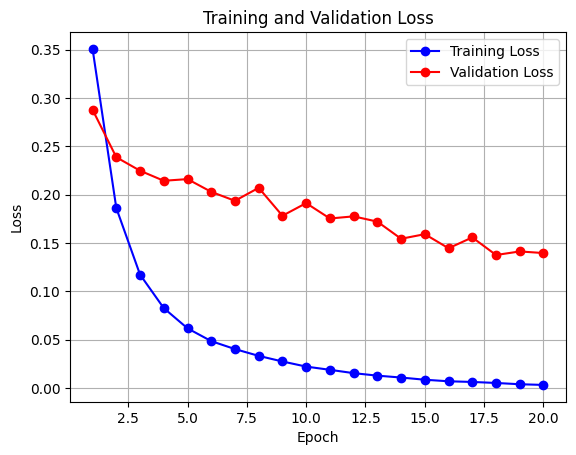

In [39]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays containing training and validation loss values for each epoch
    # Example validation loss values

epochs = range(1, len(t_loss) + 1)
plt.plot(epochs, t_loss, 'bo-', label='Training Loss')
plt.plot(epochs, v_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr =np.array(anc_img_names)
    #print("A shape", anc_img_names_arr)
    encodings = []
    model.eval()
    with torch.no_grad() :
        for i in tqdm (anc_img_names_arr):
            A = io.imread(DATA_DIR+i)
            # print("A shape:",A. shape)
            A= cv2.resize(A, (224, 224))
            A= torch.from_numpy(A).permute (2,0,1)/ 255.0
            A=A.to(DEVICE)
            print("A.unsqueeze (0)", A.unsqueeze(0).shape)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        encodings=np.array(encodings)
        encodings=pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)
    return df_enc

In [41]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/FACE/DataSet/Training'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

909


In [42]:
df=pd.DataFrame(files, columns=['Faces'])

In [43]:
model.load_state_dict(torch.load('Face_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Faces'])

  0%|                                                                                          | 0/909 [00:00<?, ?it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  0%|▎                                                                                 | 4/909 [00:00<01:35,  9.45it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  1%|▊                                                                                 | 9/909 [00:00<00:59, 15.11it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  2%|█▏                                                                               | 14/909 [00:00<00:48, 18.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  2%|█▌                                                                               | 17/909 [00:01<00:45, 19.60it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  3%|██                                                                               | 23/909 [00:01<00:41, 21.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  3%|██▌                                                                              | 29/909 [00:01<00:41, 20.97it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  4%|██▊                                                                              | 32/909 [00:01<00:43, 20.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  4%|███                                                                              | 35/909 [00:01<00:42, 20.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  5%|███▋                                                                             | 41/909 [00:02<00:40, 21.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  5%|████▏                                                                            | 47/909 [00:02<00:39, 21.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  6%|████▍                                                                            | 50/909 [00:02<00:38, 22.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  6%|████▉                                                                            | 56/909 [00:02<00:39, 21.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  7%|█████▌                                                                           | 62/909 [00:03<00:38, 21.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  7%|█████▊                                                                           | 65/909 [00:03<00:38, 21.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  8%|██████▎                                                                          | 71/909 [00:03<00:38, 21.74it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  8%|██████▊                                                                          | 77/909 [00:03<00:38, 21.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  9%|███████▏                                                                         | 80/909 [00:04<00:37, 22.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  9%|███████▋                                                                         | 86/909 [00:04<00:37, 21.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 10%|███████▉                                                                         | 89/909 [00:04<00:37, 21.67it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 10%|████████▍                                                                        | 95/909 [00:04<00:36, 22.36it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 11%|████████▉                                                                       | 101/909 [00:04<00:36, 22.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 11%|█████████▏                                                                      | 104/909 [00:05<00:36, 22.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 12%|█████████▋                                                                      | 110/909 [00:05<00:35, 22.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 13%|██████████▏                                                                     | 116/909 [00:05<00:36, 21.95it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 13%|██████████▍                                                                     | 119/909 [00:05<00:35, 21.96it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 14%|███████████                                                                     | 125/909 [00:06<00:35, 22.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 14%|███████████▎                                                                    | 128/909 [00:06<00:34, 22.43it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 15%|███████████▊                                                                    | 134/909 [00:06<00:35, 21.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 15%|████████████▎                                                                   | 140/909 [00:06<00:35, 21.96it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 16%|████████████▌                                                                   | 143/909 [00:06<00:35, 21.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 16%|█████████████                                                                   | 149/909 [00:07<00:34, 22.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 17%|█████████████▋                                                                  | 155/909 [00:07<00:34, 22.14it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 17%|█████████████▉                                                                  | 158/909 [00:07<00:33, 22.41it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 18%|██████████████▍                                                                 | 164/909 [00:07<00:34, 21.90it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 19%|██████████████▉                                                                 | 170/909 [00:08<00:32, 22.47it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 19%|███████████████▏                                                                | 173/909 [00:08<00:33, 22.11it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 20%|███████████████▊                                                                | 179/909 [00:08<00:32, 22.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 20%|████████████████▎                                                               | 185/909 [00:08<00:32, 22.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 21%|████████████████▌                                                               | 188/909 [00:08<00:33, 21.41it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 21%|█████████████████                                                               | 194/909 [00:09<00:32, 21.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 22%|█████████████████▎                                                              | 197/909 [00:09<00:32, 21.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 22%|█████████████████▊                                                              | 203/909 [00:09<00:33, 21.13it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 23%|██████████████████▍                                                             | 209/909 [00:09<00:33, 20.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 23%|██████████████████▋                                                             | 212/909 [00:10<00:33, 20.99it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 24%|███████████████████▏                                                            | 218/909 [00:10<00:33, 20.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 24%|███████████████████▍                                                            | 221/909 [00:10<00:33, 20.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 25%|███████████████████▉                                                            | 227/909 [00:10<00:31, 21.41it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 25%|████████████████████▏                                                           | 230/909 [00:10<00:31, 21.40it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 26%|████████████████████▊                                                           | 236/909 [00:11<00:31, 21.27it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 27%|█████████████████████▎                                                          | 242/909 [00:11<00:30, 21.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 27%|█████████████████████▌                                                          | 245/909 [00:11<00:29, 22.15it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 28%|██████████████████████                                                          | 251/909 [00:11<00:30, 21.31it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 28%|██████████████████████▎                                                         | 254/909 [00:11<00:30, 21.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 29%|██████████████████████▉                                                         | 260/909 [00:12<00:29, 21.94it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 29%|███████████████████████▍                                                        | 266/909 [00:12<00:28, 22.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 30%|███████████████████████▋                                                        | 269/909 [00:12<00:28, 22.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 30%|████████████████████████▏                                                       | 275/909 [00:12<00:28, 22.27it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 31%|████████████████████████▋                                                       | 281/909 [00:13<00:27, 22.63it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 31%|████████████████████████▉                                                       | 284/909 [00:13<00:27, 22.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 32%|█████████████████████████▌                                                      | 290/909 [00:13<00:28, 21.93it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 33%|██████████████████████████                                                      | 296/909 [00:13<00:28, 21.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 33%|██████████████████████████▎                                                     | 299/909 [00:14<00:27, 21.85it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 34%|██████████████████████████▊                                                     | 305/909 [00:14<00:27, 21.95it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 34%|███████████████████████████▎                                                    | 311/909 [00:14<00:26, 22.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 35%|███████████████████████████▋                                                    | 314/909 [00:14<00:26, 22.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 35%|████████████████████████████▏                                                   | 320/909 [00:14<00:26, 22.20it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 36%|████████████████████████████▋                                                   | 326/909 [00:15<00:26, 21.81it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 36%|████████████████████████████▉                                                   | 329/909 [00:15<00:25, 22.45it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 37%|█████████████████████████████▏                                                  | 332/909 [00:15<00:26, 22.13it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 37%|█████████████████████████████▋                                                  | 338/909 [00:15<00:26, 21.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 38%|██████████████████████████████▎                                                 | 344/909 [00:16<00:25, 22.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 38%|██████████████████████████████▌                                                 | 347/909 [00:16<00:25, 22.03it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 39%|███████████████████████████████                                                 | 353/909 [00:16<00:24, 22.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 39%|███████████████████████████████▌                                                | 359/909 [00:16<00:24, 22.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 40%|███████████████████████████████▊                                                | 362/909 [00:16<00:25, 21.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 40%|████████████████████████████████                                                | 365/909 [00:17<00:25, 21.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 41%|████████████████████████████████▋                                               | 371/909 [00:17<00:24, 21.96it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 41%|█████████████████████████████████▏                                              | 377/909 [00:17<00:24, 22.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 42%|█████████████████████████████████▍                                              | 380/909 [00:17<00:24, 22.04it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 42%|█████████████████████████████████▉                                              | 386/909 [00:17<00:24, 21.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 43%|██████████████████████████████████▏                                             | 389/909 [00:18<00:24, 21.25it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 43%|██████████████████████████████████▊                                             | 395/909 [00:18<00:23, 22.06it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 44%|███████████████████████████████████                                             | 398/909 [00:18<00:23, 21.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 44%|███████████████████████████████████▌                                            | 404/909 [00:18<00:22, 22.47it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 45%|████████████████████████████████████                                            | 410/909 [00:19<00:21, 22.70it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 45%|████████████████████████████████████▎                                           | 413/909 [00:19<00:22, 22.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 46%|████████████████████████████████████▉                                           | 419/909 [00:19<00:22, 22.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 47%|█████████████████████████████████████▍                                          | 425/909 [00:19<00:21, 22.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 47%|█████████████████████████████████████▋                                          | 428/909 [00:19<00:21, 22.24it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 48%|██████████████████████████████████████▏                                         | 434/909 [00:20<00:21, 22.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 48%|██████████████████████████████████████▍                                         | 437/909 [00:20<00:22, 21.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 49%|██████████████████████████████████████▉                                         | 443/909 [00:20<00:21, 21.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 49%|███████████████████████████████████████▎                                        | 446/909 [00:20<00:21, 21.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 50%|███████████████████████████████████████▊                                        | 452/909 [00:20<00:20, 21.90it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 50%|████████████████████████████████████████▎                                       | 458/909 [00:21<00:20, 21.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 51%|████████████████████████████████████████▌                                       | 461/909 [00:21<00:21, 21.13it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 51%|█████████████████████████████████████████                                       | 467/909 [00:21<00:20, 21.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 52%|█████████████████████████████████████████▋                                      | 473/909 [00:21<00:20, 21.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 52%|█████████████████████████████████████████▉                                      | 476/909 [00:22<00:19, 21.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 53%|██████████████████████████████████████████▍                                     | 482/909 [00:22<00:19, 21.94it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 53%|██████████████████████████████████████████▋                                     | 485/909 [00:22<00:19, 21.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 54%|███████████████████████████████████████████▏                                    | 491/909 [00:22<00:18, 22.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 55%|███████████████████████████████████████████▋                                    | 497/909 [00:23<00:18, 21.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 55%|████████████████████████████████████████████                                    | 500/909 [00:23<00:18, 21.93it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 56%|████████████████████████████████████████████▌                                   | 506/909 [00:23<00:17, 22.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 56%|█████████████████████████████████████████████                                   | 512/909 [00:23<00:17, 22.43it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 57%|█████████████████████████████████████████████▎                                  | 515/909 [00:23<00:17, 22.12it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 57%|█████████████████████████████████████████████▊                                  | 521/909 [00:24<00:17, 22.60it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 58%|██████████████████████████████████████████████▍                                 | 527/909 [00:24<00:17, 22.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 58%|██████████████████████████████████████████████▋                                 | 530/909 [00:24<00:17, 21.95it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 59%|███████████████████████████████████████████████▏                                | 536/909 [00:24<00:17, 21.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 60%|███████████████████████████████████████████████▋                                | 542/909 [00:25<00:17, 21.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 60%|███████████████████████████████████████████████▉                                | 545/909 [00:25<00:16, 21.83it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 61%|████████████████████████████████████████████████▍                               | 551/909 [00:25<00:16, 21.63it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 61%|█████████████████████████████████████████████████                               | 557/909 [00:25<00:16, 21.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 62%|█████████████████████████████████████████████████▎                              | 560/909 [00:25<00:16, 21.69it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 62%|█████████████████████████████████████████████████▊                              | 566/909 [00:26<00:15, 22.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 63%|██████████████████████████████████████████████████▎                             | 572/909 [00:26<00:15, 21.36it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 63%|██████████████████████████████████████████████████▌                             | 575/909 [00:26<00:15, 21.85it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 64%|███████████████████████████████████████████████████▏                            | 581/909 [00:26<00:15, 21.81it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 64%|███████████████████████████████████████████████████▍                            | 584/909 [00:26<00:14, 21.69it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 65%|███████████████████████████████████████████████████▉                            | 590/909 [00:27<00:14, 22.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 66%|████████████████████████████████████████████████████▍                           | 596/909 [00:27<00:14, 21.93it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 66%|████████████████████████████████████████████████████▋                           | 599/909 [00:27<00:13, 22.27it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 67%|█████████████████████████████████████████████████████▏                          | 605/909 [00:27<00:13, 21.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 67%|█████████████████████████████████████████████████████▌                          | 608/909 [00:28<00:13, 21.69it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 68%|██████████████████████████████████████████████████████                          | 614/909 [00:28<00:13, 21.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 68%|██████████████████████████████████████████████████████▌                         | 620/909 [00:28<00:12, 22.48it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 69%|██████████████████████████████████████████████████████▊                         | 623/909 [00:28<00:12, 22.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 69%|███████████████████████████████████████████████████████▎                        | 629/909 [00:29<00:12, 22.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 70%|███████████████████████████████████████████████████████▌                        | 632/909 [00:29<00:12, 22.07it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 70%|████████████████████████████████████████████████████████▏                       | 638/909 [00:29<00:12, 22.58it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 71%|████████████████████████████████████████████████████████▋                       | 644/909 [00:29<00:11, 22.66it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 71%|████████████████████████████████████████████████████████▉                       | 647/909 [00:29<00:11, 22.28it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 72%|█████████████████████████████████████████████████████████▍                      | 653/909 [00:30<00:11, 21.69it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 72%|█████████████████████████████████████████████████████████▋                      | 656/909 [00:30<00:12, 20.72it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 73%|██████████████████████████████████████████████████████████▎                     | 662/909 [00:30<00:11, 21.37it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 73%|██████████████████████████████████████████████████████████▊                     | 668/909 [00:30<00:11, 21.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 74%|███████████████████████████████████████████████████████████                     | 671/909 [00:30<00:10, 21.65it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 74%|███████████████████████████████████████████████████████████▌                    | 677/909 [00:31<00:10, 21.86it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 75%|████████████████████████████████████████████████████████████                    | 683/909 [00:31<00:10, 21.99it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 75%|████████████████████████████████████████████████████████████▎                   | 686/909 [00:31<00:10, 21.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 76%|████████████████████████████████████████████████████████████▉                   | 692/909 [00:31<00:10, 21.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 76%|█████████████████████████████████████████████████████████████▏                  | 695/909 [00:32<00:10, 20.85it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 77%|█████████████████████████████████████████████████████████████▍                  | 698/909 [00:32<00:10, 20.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 77%|█████████████████████████████████████████████████████████████▉                  | 704/909 [00:32<00:10, 20.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 78%|██████████████████████████████████████████████████████████████▏                 | 707/909 [00:32<00:09, 20.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 78%|██████████████████████████████████████████████████████████████▊                 | 713/909 [00:32<00:09, 20.54it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 79%|███████████████████████████████████████████████████████████████                 | 716/909 [00:33<00:09, 19.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 79%|███████████████████████████████████████████████████████████████▌                | 722/909 [00:33<00:08, 21.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 80%|███████████████████████████████████████████████████████████████▊                | 725/909 [00:33<00:08, 20.83it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 80%|████████████████████████████████████████████████████████████████                | 728/909 [00:33<00:08, 21.46it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 81%|████████████████████████████████████████████████████████████████▌               | 734/909 [00:33<00:08, 21.42it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 81%|█████████████████████████████████████████████████████████████████▏              | 740/909 [00:34<00:07, 21.63it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 82%|█████████████████████████████████████████████████████████████████▍              | 743/909 [00:34<00:07, 22.04it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 82%|█████████████████████████████████████████████████████████████████▉              | 749/909 [00:34<00:07, 22.21it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 83%|██████████████████████████████████████████████████████████████████▍             | 755/909 [00:34<00:07, 21.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 83%|██████████████████████████████████████████████████████████████████▋             | 758/909 [00:35<00:06, 21.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 84%|███████████████████████████████████████████████████████████████████▏            | 764/909 [00:35<00:06, 22.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 84%|███████████████████████████████████████████████████████████████████▌            | 767/909 [00:35<00:06, 22.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 85%|████████████████████████████████████████████████████████████████████            | 773/909 [00:35<00:06, 22.46it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 86%|████████████████████████████████████████████████████████████████████▌           | 779/909 [00:35<00:05, 22.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 86%|████████████████████████████████████████████████████████████████████▊           | 782/909 [00:36<00:05, 22.09it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 87%|█████████████████████████████████████████████████████████████████████▎          | 788/909 [00:36<00:05, 22.62it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 87%|█████████████████████████████████████████████████████████████████████▉          | 794/909 [00:36<00:05, 22.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 88%|██████████████████████████████████████████████████████████████████████▏         | 797/909 [00:36<00:05, 22.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 88%|██████████████████████████████████████████████████████████████████████▋         | 803/909 [00:37<00:04, 22.45it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 89%|███████████████████████████████████████████████████████████████████████▏        | 809/909 [00:37<00:04, 22.40it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 89%|███████████████████████████████████████████████████████████████████████▍        | 812/909 [00:37<00:04, 22.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 90%|███████████████████████████████████████████████████████████████████████▉        | 818/909 [00:37<00:04, 22.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 91%|████████████████████████████████████████████████████████████████████████▌       | 824/909 [00:38<00:03, 21.96it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 91%|████████████████████████████████████████████████████████████████████████▊       | 827/909 [00:38<00:03, 22.29it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 92%|█████████████████████████████████████████████████████████████████████████▎      | 833/909 [00:38<00:03, 22.25it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 92%|█████████████████████████████████████████████████████████████████████████▌      | 836/909 [00:38<00:03, 22.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 93%|██████████████████████████████████████████████████████████████████████████      | 842/909 [00:38<00:02, 22.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 93%|██████████████████████████████████████████████████████████████████████████▋     | 848/909 [00:39<00:02, 22.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 94%|██████████████████████████████████████████████████████████████████████████▉     | 851/909 [00:39<00:02, 22.37it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 94%|███████████████████████████████████████████████████████████████████████████▍    | 857/909 [00:39<00:02, 22.20it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 95%|███████████████████████████████████████████████████████████████████████████▉    | 863/909 [00:39<00:02, 22.52it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 95%|████████████████████████████████████████████████████████████████████████████▏   | 866/909 [00:39<00:01, 22.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 96%|████████████████████████████████████████████████████████████████████████████▋   | 872/909 [00:40<00:01, 21.97it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 878/909 [00:40<00:01, 22.00it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 881/909 [00:40<00:01, 22.31it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 98%|██████████████████████████████████████████████████████████████████████████████  | 887/909 [00:40<00:00, 22.34it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 893/909 [00:41<00:00, 22.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 896/909 [00:41<00:00, 22.43it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 99%|███████████████████████████████████████████████████████████████████████████████▍| 902/909 [00:41<00:00, 21.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


100%|███████████████████████████████████████████████████████████████████████████████▉| 908/909 [00:41<00:00, 22.54it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


100%|████████████████████████████████████████████████████████████████████████████████| 909/909 [00:41<00:00, 21.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])


In [44]:
df_enc.to_csv("Embeddings_training.csv", index=False)

In [130]:
df_enc = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Embeddings_training.csv')

In [131]:
faces_list = list(df_enc['Faces'])

In [48]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/FACE/DataSet/Validation'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

302


In [49]:
df=pd.DataFrame(files, columns=['Faces'])

In [50]:
model.load_state_dict(torch.load('Face_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Faces'])

  1%|█                                                                                 | 4/302 [00:00<00:22, 13.32it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  2%|█▉                                                                                | 7/302 [00:00<00:17, 16.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  4%|███▍                                                                             | 13/302 [00:00<00:14, 19.86it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  6%|█████                                                                            | 19/302 [00:01<00:13, 20.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  7%|█████▉                                                                           | 22/302 [00:01<00:13, 21.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  9%|███████▌                                                                         | 28/302 [00:01<00:13, 19.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 10%|████████▎                                                                        | 31/302 [00:01<00:13, 20.28it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 12%|█████████▉                                                                       | 37/302 [00:01<00:13, 19.85it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 13%|██████████▋                                                                      | 40/302 [00:02<00:12, 20.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 14%|███████████▌                                                                     | 43/302 [00:02<00:12, 20.03it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 16%|█████████████▏                                                                   | 49/302 [00:02<00:12, 19.62it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 17%|█████████████▉                                                                   | 52/302 [00:02<00:12, 20.11it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 19%|███████████████▌                                                                 | 58/302 [00:02<00:11, 21.15it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 21%|█████████████████▏                                                               | 64/302 [00:03<00:11, 21.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 22%|█████████████████▉                                                               | 67/302 [00:03<00:10, 21.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 24%|███████████████████▌                                                             | 73/302 [00:03<00:10, 21.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 25%|████████████████████▍                                                            | 76/302 [00:03<00:10, 22.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 27%|█████████████████████▉                                                           | 82/302 [00:04<00:10, 20.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 28%|██████████████████████▊                                                          | 85/302 [00:04<00:10, 20.72it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 30%|████████████████████████▍                                                        | 91/302 [00:04<00:10, 20.77it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 32%|██████████████████████████                                                       | 97/302 [00:04<00:09, 21.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 33%|██████████████████████████▍                                                     | 100/302 [00:04<00:09, 21.28it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 35%|████████████████████████████                                                    | 106/302 [00:05<00:08, 21.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 36%|████████████████████████████▊                                                   | 109/302 [00:05<00:08, 21.70it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 38%|██████████████████████████████▍                                                 | 115/302 [00:05<00:08, 22.09it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 40%|████████████████████████████████                                                | 121/302 [00:05<00:08, 21.75it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 41%|████████████████████████████████▊                                               | 124/302 [00:06<00:08, 21.65it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 42%|█████████████████████████████████▋                                              | 127/302 [00:06<00:08, 21.70it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 44%|███████████████████████████████████▏                                            | 133/302 [00:06<00:07, 22.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 46%|████████████████████████████████████▊                                           | 139/302 [00:06<00:07, 22.00it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 47%|█████████████████████████████████████▌                                          | 142/302 [00:06<00:07, 21.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 49%|███████████████████████████████████████▏                                        | 148/302 [00:07<00:07, 21.40it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 50%|████████████████████████████████████████                                        | 151/302 [00:07<00:07, 20.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 52%|█████████████████████████████████████████▌                                      | 157/302 [00:07<00:07, 20.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 53%|██████████████████████████████████████████▍                                     | 160/302 [00:07<00:07, 20.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 55%|███████████████████████████████████████████▉                                    | 166/302 [00:08<00:06, 20.60it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 56%|████████████████████████████████████████████▊                                   | 169/302 [00:08<00:06, 20.65it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 58%|██████████████████████████████████████████████▎                                 | 175/302 [00:08<00:05, 21.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 59%|███████████████████████████████████████████████▏                                | 178/302 [00:08<00:05, 21.47it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 61%|████████████████████████████████████████████████▋                               | 184/302 [00:08<00:05, 20.70it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 62%|█████████████████████████████████████████████████▌                              | 187/302 [00:09<00:05, 20.90it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 64%|███████████████████████████████████████████████████▏                            | 193/302 [00:09<00:05, 21.48it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 66%|████████████████████████████████████████████████████▋                           | 199/302 [00:09<00:04, 20.83it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 67%|█████████████████████████████████████████████████████▌                          | 202/302 [00:09<00:04, 21.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 68%|██████████████████████████████████████████████████████▎                         | 205/302 [00:09<00:04, 20.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 70%|███████████████████████████████████████████████████████▉                        | 211/302 [00:10<00:04, 21.34it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 72%|█████████████████████████████████████████████████████████▍                      | 217/302 [00:10<00:03, 21.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 73%|██████████████████████████████████████████████████████████▎                     | 220/302 [00:10<00:03, 21.63it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 75%|███████████████████████████████████████████████████████████▊                    | 226/302 [00:10<00:03, 21.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 77%|█████████████████████████████████████████████████████████████▍                  | 232/302 [00:11<00:03, 21.77it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 78%|██████████████████████████████████████████████████████████████▎                 | 235/302 [00:11<00:03, 22.15it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 80%|███████████████████████████████████████████████████████████████▊                | 241/302 [00:11<00:02, 22.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 82%|█████████████████████████████████████████████████████████████████▍              | 247/302 [00:11<00:02, 21.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 83%|██████████████████████████████████████████████████████████████████▏             | 250/302 [00:11<00:02, 21.32it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 85%|███████████████████████████████████████████████████████████████████▊            | 256/302 [00:12<00:02, 21.70it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 86%|████████████████████████████████████████████████████████████████████▌           | 259/302 [00:12<00:01, 22.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 88%|██████████████████████████████████████████████████████████████████████▏         | 265/302 [00:12<00:01, 22.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 90%|███████████████████████████████████████████████████████████████████████▊        | 271/302 [00:12<00:01, 21.08it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 91%|████████████████████████████████████████████████████████████████████████▌       | 274/302 [00:13<00:01, 21.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 93%|██████████████████████████████████████████████████████████████████████████▏     | 280/302 [00:13<00:01, 21.30it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 94%|██████████████████████████████████████████████████████████████████████████▉     | 283/302 [00:13<00:00, 21.26it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 96%|████████████████████████████████████████████████████████████████████████████▌   | 289/302 [00:13<00:00, 21.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 295/302 [00:14<00:00, 21.54it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 298/302 [00:14<00:00, 21.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:14<00:00, 21.05it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])


In [51]:
df_enc.to_csv("Embeddings_validation.csv", index=False)

In [2]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/FACE/DataSet/Testing'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

302


In [11]:
df=pd.DataFrame(files, columns=['Faces'])

In [16]:
model.load_state_dict(torch.load('Face_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Faces'])

  0%|                                                                                          | 0/302 [00:00<?, ?it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  1%|█                                                                                 | 4/302 [00:01<01:11,  4.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  4%|██▉                                                                              | 11/302 [00:01<00:22, 13.06it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


  7%|█████▋                                                                           | 21/302 [00:01<00:11, 25.10it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 13%|██████████▏                                                                      | 38/302 [00:01<00:05, 45.41it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 15%|████████████                                                                     | 45/302 [00:01<00:05, 51.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 20%|████████████████                                                                 | 60/302 [00:02<00:04, 55.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 25%|████████████████████▍                                                            | 76/302 [00:02<00:03, 66.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 31%|█████████████████████████▏                                                       | 94/302 [00:02<00:02, 73.47it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 37%|█████████████████████████████▋                                                  | 112/302 [00:02<00:02, 78.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 40%|████████████████████████████████                                                | 121/302 [00:02<00:02, 81.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 46%|████████████████████████████████████▌                                           | 138/302 [00:03<00:02, 70.92it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 51%|█████████████████████████████████████████                                       | 155/302 [00:03<00:02, 73.08it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 57%|█████████████████████████████████████████████▌                                  | 172/302 [00:03<00:01, 75.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 63%|██████████████████████████████████████████████████                              | 189/302 [00:03<00:01, 72.16it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 65%|████████████████████████████████████████████████████▏                           | 197/302 [00:04<00:01, 70.46it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 70%|████████████████████████████████████████████████████████▏                       | 212/302 [00:04<00:01, 67.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 75%|████████████████████████████████████████████████████████████▏                   | 227/302 [00:04<00:01, 65.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 80%|███████████████████████████████████████████████████████████████▊                | 241/302 [00:04<00:00, 65.67it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 85%|████████████████████████████████████████████████████████████████████            | 257/302 [00:04<00:00, 71.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 90%|████████████████████████████████████████████████████████████████████████▎       | 273/302 [00:05<00:00, 73.39it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 93%|██████████████████████████████████████████████████████████████████████████▍     | 281/302 [00:05<00:00, 73.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 296/302 [00:05<00:00, 57.21it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:05<00:00, 53.11it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


In [17]:
df_enc.to_csv("Embeddings_Testing.csv", index=False)

## Calculating Accuracy

In [9]:
df_valid = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Embeddings_validation.csv')
train_df= pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Embeddings_training.csv')
df_test= pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/FACE/Embeddings_testing.csv')
faces_list = list(train_df['Faces'])

In [10]:
train_df.shape

(909, 514)

In [11]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = df_valid.iloc[:, :-1]
y_test = df_valid.iloc[:, -1]

In [12]:
def euclidean_dist (img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot (img_enc - anc_enc_arr,(img_enc-anc_enc_arr).T))
    return dist

In [13]:
anc_enc_arr = X_train.iloc[:,1:].to_numpy()
anc_enc_arr.shape

(909, 512)

In [14]:
ln = X_test.shape[0]
r = X_train.shape[0]
print(ln, r)

302 909


In [15]:
centroids_df = train_df.groupby('Label', as_index=False)[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511']].mean()

In [16]:
centroids_df.head()

Label         0         1         2         3         4         5  \
0     Akshay -0.001739  0.029244  0.024333 -0.043668  0.052443 -0.019329   
1  Alexandra -0.022676  0.030212 -0.007441  0.081797  0.070382 -0.029765   
2       Alia  0.072749 -0.013756  0.036756 -0.052611 -0.022043  0.017118   
3    Amitabh -0.028591 -0.000955 -0.021861  0.019770  0.041448 -0.038672   
4       Andy  0.021015  0.015913  0.029243 -0.023929 -0.056689  0.023845   

          6         7         8  ...       502       503       504       505  \
0  0.050588  0.015775  0.015151  ... -0.004696  0.052489 -0.056866  0.081940   
1  0.045077 -0.058593 -0.015934  ... -0.019933 -0.064603 -0.027249 -0.096011   
2  0.061381 -0.075509 -0.019890  ...  0.009297  0.041443 -0.020225 -0.034808   
3 -0.051416 -0.084690  0.065106  ...  0.035461  0.001526  0.021301  0.024205   
4  0.086472  0.073672  0.029895  ...  0.020862 -0.054733 -0.011423  0.019043   

        506       507       508       509       510       511  
0  0.086967  0.046692  0.061591  0.049405 -0.058697 -0.012268  
1 -0.043455  0.022291  0.068324  0.024470 -0.036688  0.010538  
2  0.058285  0.046943 -0.083577  0.005587  0.029707 -0.004824  
3 -0.002029  0.006408  0.052746 -0.030661  0.009759  0.026656  
4 -0.009025 -0.002159 -0.001954 -0.023493  0.070893 -0.006104  

[5 rows x 513 columns]

In [17]:
dig_list = centroids_df.iloc[:,0]
dig_list = list(dig_list)
dig_list

['Akshay',
 'Alexandra',
 'Alia',
 'Amitabh',
 'Andy',
 'Anushka',
 'Billie',
 'Brad',
 'Camila',
 'Charlize',
 'Claire',
 'Courtney',
 'Dwayne',
 'Elizabeth',
 'Ellen',
 'Henry',
 'Hrithik',
 'Hugh',
 'Jessica',
 'Kashyap',
 'Lisa',
 'Margot',
 'Marmik',
 'Natalie',
 'Priyanka',
 'Robert',
 'Roger',
 'Tom',
 'Vijay',
 'Virat',
 'Zac']

In [18]:
anc_enc_arr = centroids_df.iloc[:,1:].to_numpy()
r = anc_enc_arr.shape[0]
print(r)

31


In [24]:
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = X_test.iloc[i,1:]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_valid.iloc[i][-1] == nearest_img):
        count+=1
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_1172\4207896954.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_

In [25]:
print(count)

281


In [26]:
acc = (count/ln)*100

In [27]:
print("Accuracy is :",acc)

Accuracy is : 93.04635761589404


## ClassWise Accuracy Caclulation - Validation

In [70]:
l = []
df_val_0 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Akshay Kumar/Akshay Kumar.csv')
df_val_1 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Alexandra Daddario/Alexandra Daddario.csv')
df_val_2 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Alia Bhatt/Alia.csv')
df_val_3 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Amitabh Bachchan/Amitabh Bachchan.csv')
df_val_4 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Andy Samberg/Andy Samberg.csv')
df_val_5 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Anushka Sharma/Anushka Sharma.csv')
df_val_6 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Billie Eilish/Billie Eilish.csv')
df_val_7 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Brad Pitt/Brad Pitt.csv')
df_val_8 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Camila Cabello/Camila Cabello.csv')
df_val_9 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Charlize Theron/Charlize Theron.csv')
df_val_10 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Claire Holt/Claire Holt.csv')
df_val_11 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Courtney Cox/Courtney Cox.csv')
df_val_12 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Dwayne Johnson/Dwayne Johnson.csv')
df_val_13 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Elizabeth Olsen/Elizabeth Olsen.csv')
df_val_14 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Ellen Degeneres/Ellen Degeneres.csv')
df_val_15 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Henry Cavill/Henry Cavill.csv')
df_val_16 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Hrithik Roshan/Hrithik Roshan.csv')
df_val_17 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Hugh Jackman/Hugh Jackman.csv')
df_val_18 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Jessica Alba/Jessica Alba.csv')
df_val_19 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Kashyap/Kashyap.csv')
df_val_20 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Lisa Kudrow/Lisa Kudrow.csv')
df_val_21 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Margot Robbie/Margot Robbie.csv')
df_val_22 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Marmik/Marmik.csv')
df_val_23 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Natalie Portman/Natalie Portman.csv')
df_val_24 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Priyanka Chopra/Priyanka Chopra.csv')
df_val_25 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Robert Downey Jr/Robert Downey Jr.csv')
df_val_26 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Roger Federer/Roger Federer.csv')
df_val_27 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Tom Cruise/Tom Cruise.csv')
df_val_28 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Vijay Deverakonda/Vijay Deverakonda.csv')
df_val_29 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Virat Kohli/Virat Kohli.csv')
df_val_30 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Validation/Zac Efron/Zac Efron.csv')
l=[df_val_0,df_val_1,df_val_2,df_val_3,df_val_4,df_val_5,df_val_6,df_val_7,df_val_8,df_val_9, df_val_10, df_val_11, df_val_12, df_val_13, df_val_14, df_val_15, df_val_16, df_val_17, df_val_18, df_val_19, df_val_20, df_val_21, df_val_22, df_val_23, df_val_24, df_val_25, df_val_26, df_val_27, df_val_28, df_val_29, df_val_30]

In [71]:
for u in range(31):
    print(l[u].shape)

(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(11, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)


In [63]:
Acc=[]
lx = len(l)
for x in range(0,lx):
    i=0
    j=0
    count=0
    for i in range(0, 10):
        img_enc = l[x].iloc[i,1:-1]
        img_enc = pd.DataFrame([img_enc])
        img_enc = torch.tensor(img_enc.values)
        distance ={}
        j=0
        for j in range(0,r):
            dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
            distance[dig_list[j]] = dist
            j+=1
        sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
        dist_sort = sorted_dist.keys()
        dist_sort = list(dist_sort)
        nearest_img = dist_sort[0]
        if(l[x].iloc[i][-1] == nearest_img):
            count+=1
        i+=1
        a=(count/10)*100
        a = round(a, 1)
    x=x+1
    Acc.append(a)


C:\Users\asingh74\AppData\Local\Temp\ipykernel_24856\2889650039.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(l[x].iloc[i][-1] == nearest_img):


In [64]:
print(Acc)

[70.0, 100.0, 90.0, 100.0, 90.0, 90.0, 90.0, 100.0, 100.0, 80.0, 90.0, 80.0, 100.0, 100.0, 100.0, 100.0, 90.0, 100.0, 90.0, 60.0, 100.0, 100.0, 100.0, 90.0, 100.0, 100.0, 100.0, 80.0, 100.0, 100.0, 80.0]


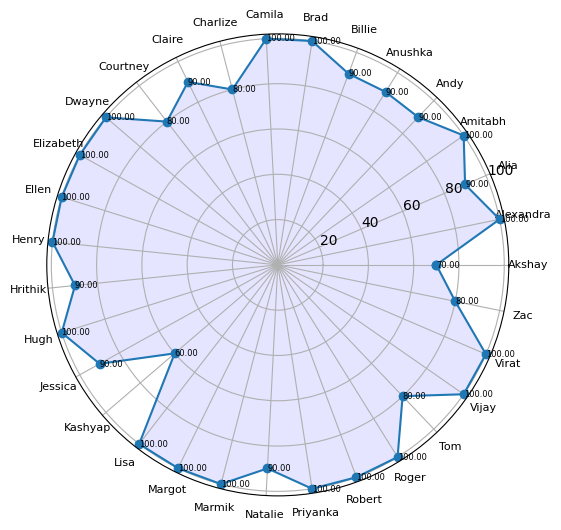

In [69]:
import numpy as np
import matplotlib.pyplot as plt


accuracies = Acc


num_classes = len(accuracies)


angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()


accuracies = np.concatenate((accuracies,[accuracies[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, accuracies, marker='o')
ax.fill(angles, accuracies, 'blue', alpha=0.1)


for angle, accuracy in zip(angles[:-1], accuracies[:-1]):
    ax.annotate('{:.2f}'.format(accuracy), xy=(angle, accuracy), xytext=(angle, accuracy + 0.05),
                ha='left', va='center', fontsize=6, color='black')


ax.set_xticks(angles[:-1])
ax.set_xticklabels(['{}'.format(dig_list[i]) for i in range(num_classes)], fontsize=8)
plt.show()


In [87]:
df_valid.shape

(302, 514)

## Confusion Matrix for Validation Data

In [72]:
pred=[]
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_valid.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    pred.append(dist_sort[0])
#     if (nearest_img == dist_sort[0]):
#         pred.append(nearest_img)

In [73]:
print(len(pred))

302


In [86]:
print(ln)

302


In [74]:
act = df_valid.iloc[:,-1]

In [94]:
print(len(act))

302


In [75]:
pred = pd.DataFrame(pred,columns=['Label'])
print(len(pred))

302


In [77]:
from sklearn import metrics

In [78]:

conf_matrix = metrics.confusion_matrix(act, pred)
conf_df = pd.DataFrame(conf_matrix, index=['Actual {}'.format(i) for i in range(31)], columns=['Predicted {}'.format(i) for i in range(31)])

conf_df




Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0             7            0            0            0            0   
Actual 1             0           10            0            0            0   
Actual 2             0            0            9            0            0   
Actual 3             0            0            0           10            0   
Actual 4             0            0            0            0            9   
Actual 5             0            0            0            0            0   
Actual 6             0            0            0            0            0   
Actual 7             0            0            0            0            0   
Actual 8             0            0            0            0            0   
Actual 9             0            0            0            0            0   
Actual 10            0            0            0            0            0   
Actual 11            0            2            0            0            0   
Actual 12            0            0            0            0            0   
Actual 13            0            0            0            0            0   
Actual 14            0            0            0            0            0   
Actual 15            0            0            0            0            0   
Actual 16            0            0            0            0            0   
Actual 17            0            0            0            0            0   
Actual 18            0            0            0            0            0   
Actual 19            0            0            0            0            0   
Actual 20            0            0            0            0            0   
Actual 21            0            0            0            0            0   
Actual 22            0            0            0            0            0   
Actual 23            0            0            0            0            0   
Actual 24            0            0            0            0            0   
Actual 25            0            0            0            0            0   
Actual 26            0            0            0            0            0   
Actual 27            0            0            0            0            0   
Actual 28            0            0            0            0            0   
Actual 29            0            0            0            0            0   
Actual 30            0            0            0            0            0   

           Predicted 5  Predicted 6  Predicted 7  Predicted 8  Predicted 9  \
Actual 0             0            0            0            0            0   
Actual 1             0            0            0            0            0   
Actual 2             0            0            0            0            0   
Actual 3             0            0            0            0            0   
Actual 4             1            0            0            0            0   
Actual 5             9            0            0            0            0   
Actual 6             0            9            0            0            0   
Actual 7             0            0           10            0            0   
Actual 8             0            0            0           10            0   
Actual 9             0            0            0            0            8   
Actual 10            0            0            0            0            0   
Actual 11            0            0            0            0            0   
Actual 12            0            0            0            0            0   
Actual 13            0            0            0            0            0   
Actual 14            0            0            0            0            0   
Actual 15            0            0            0            0            0   
Actual 16            0            0            0            0            0   
Actual 17            0            0            0            0            0   
Actual 18            0          

## ClassWise Accuracy Caclulation - Testing

In [104]:
l = []
df_val_0 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Akshay Kumar/Akshay Kumar.csv')
df_val_1 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Alexandra Daddario/Alexandra Daddario.csv')
df_val_2 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Alia Bhatt/Alia.csv')
df_val_3 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Amitabh Bachchan/Amitabh Bachchan.csv')
df_val_4 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Andy Samberg/Andy Samberg.csv')
df_val_5 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Anushka Sharma/Anushka Sharma.csv')
df_val_6 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Billie Eilish/Billie Eilish.csv')
df_val_7 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Brad Pitt/Brad Pitt.csv')
df_val_8 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Camila Cabello/Camila Cabello.csv')
df_val_9 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Charlize Theron/Charlize Theron.csv')
df_val_10 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Claire Holt/Claire Holt.csv')
df_val_11 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Courtney Cox/Courtney Cox.csv')
df_val_12 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Dwayne Johnson/Dwayne Johnson.csv')
df_val_13 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Elizabeth Olsen/Elizabeth Olsen.csv')
df_val_14 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Ellen Degeneres/Ellen Degeneres.csv')
df_val_15 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Henry Cavill/Henry Cavill.csv')
df_val_16 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Hrithik Roshan/Hrithik Roshan.csv')
df_val_17 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Hugh Jackman/Hugh Jackman.csv')
df_val_18 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Jessica Alba/Jessica Alba.csv')
df_val_19 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Kashyap/Kashyap.csv')
df_val_20 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Lisa Kudrow/Lisa Kudrow.csv')
df_val_21 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Margot Robbie/Margot Robbie.csv')
df_val_22 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Marmik/Marmik.csv')
df_val_23 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Natalie Portman/Natalie Portman.csv')
df_val_24 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Priyanka Chopra/Priyanka Chopra.csv')
df_val_25 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Robert Downey Jr/Robert Downey Jr.csv')
df_val_26 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Roger Federer/Roger Federer.csv')
df_val_27 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Tom Cruise/Tom Cruise.csv')
df_val_28 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Vijay Deverakonda/Vijay Deverakonda.csv')
df_val_29 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Virat Kohli/Virat Kohli.csv')
df_val_30 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/Face/ClassWise Accuracy/Testing/Zac Efron/Zac Efron.csv')
l=[df_val_0,df_val_1,df_val_2,df_val_3,df_val_4,df_val_5,df_val_6,df_val_7,df_val_8,df_val_9, df_val_10, df_val_11, df_val_12, df_val_13, df_val_14, df_val_15, df_val_16, df_val_17, df_val_18, df_val_19, df_val_20, df_val_21, df_val_22, df_val_23, df_val_24, df_val_25, df_val_26, df_val_27, df_val_28, df_val_29, df_val_30]

In [105]:
for u in range(31):
    print(l[u].shape)

(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(10, 514)
(13, 514)
(10, 514)


In [106]:
Acc=[]
lx = len(l)
for x in range(0,lx):
    i=0
    j=0
    count=0
    for i in range(0, 10):
        img_enc = l[x].iloc[i,1:-1]
        img_enc = pd.DataFrame([img_enc])
        img_enc = torch.tensor(img_enc.values)
        distance ={}
        j=0
        for j in range(0,r):
            dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
            distance[dig_list[j]] = dist
            j+=1
        sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
        dist_sort = sorted_dist.keys()
        dist_sort = list(dist_sort)
        nearest_img = dist_sort[0]
        if(l[x].iloc[i][-1] == nearest_img):
            count+=1
        i+=1
        a=(count/10)*100
        a = round(a, 1)
    x=x+1
    Acc.append(a)


C:\Users\asingh74\AppData\Local\Temp\ipykernel_24856\2889650039.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(l[x].iloc[i][-1] == nearest_img):


In [107]:
print(Acc)

[90.0, 100.0, 100.0, 100.0, 90.0, 80.0, 90.0, 70.0, 90.0, 90.0, 60.0, 90.0, 90.0, 100.0, 100.0, 60.0, 100.0, 90.0, 90.0, 100.0, 90.0, 80.0, 100.0, 80.0, 100.0, 70.0, 100.0, 80.0, 100.0, 100.0, 100.0]


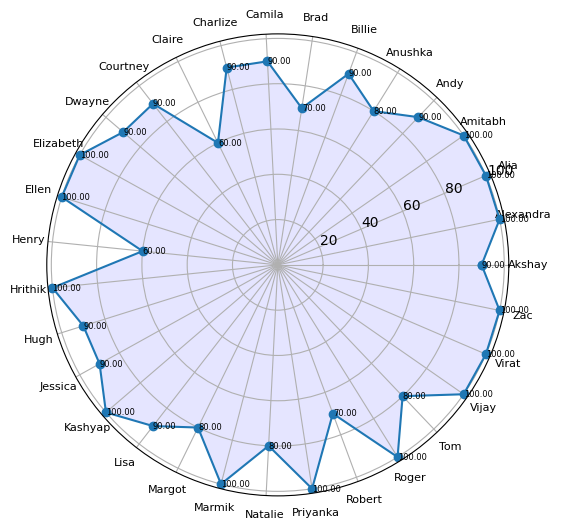

In [108]:
import numpy as np
import matplotlib.pyplot as plt


accuracies = Acc


num_classes = len(accuracies)


angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()


accuracies = np.concatenate((accuracies,[accuracies[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, accuracies, marker='o')
ax.fill(angles, accuracies, 'blue', alpha=0.1)


for angle, accuracy in zip(angles[:-1], accuracies[:-1]):
    ax.annotate('{:.2f}'.format(accuracy), xy=(angle, accuracy), xytext=(angle, accuracy + 0.05),
                ha='left', va='center', fontsize=6, color='black')


ax.set_xticks(angles[:-1])
ax.set_xticklabels(['{}'.format(dig_list[i]) for i in range(num_classes)], fontsize=8)
plt.show()


## Confusion Matrix for Testing Data

In [79]:
pred=[]
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_test.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    pred.append(dist_sort[0])
#     if (nearest_img == dist_sort[0]):
#         pred.append(nearest_img)

In [80]:
act = df_valid.iloc[:,-1]

In [81]:
pred = pd.DataFrame(pred,columns=['Label'])
print(len(pred))

302


In [82]:
from sklearn.metrics import confusion_matrix

In [83]:

conf_matrix = confusion_matrix(act, pred)
conf_df = pd.DataFrame(conf_matrix, index=['Actual {}'.format(dig_list[i]) for i in range(31)], columns=['Predicted {}'.format(dig_list[i]) for i in range(31)])

conf_df


Predicted Akshay  Predicted Alexandra  Predicted Alia  \
Actual Akshay                    9                    0               0   
Actual Alexandra                 0                   10               0   
Actual Alia                      0                    0              10   
Actual Amitabh                   0                    0               0   
Actual Andy                      0                    0               0   
Actual Anushka                   0                    0               2   
Actual Billie                    0                    0               0   
Actual Brad                      0                    0               0   
Actual Camila                    0                    0               0   
Actual Charlize                  0                    0               0   
Actual Claire                    0                    0               0   
Actual Courtney                  0                    0               0   
Actual Dwayne                    0                    0               0   
Actual Elizabeth                 0                    0               0   
Actual Ellen                     0                    0               0   
Actual Henry                     0                    0               0   
Actual Hrithik                   0                    0               0   
Actual Hugh                      0                    0               0   
Actual Jessica                   0                    0               0   
Actual Kashyap                   0                    0               0   
Actual Lisa                      0                    0               0   
Actual Margot                    0                    0               0   
Actual Marmik                    0                    0               0   
Actual Natalie                   0                    0               0   
Actual Priyanka                  0                    0               0   
Actual Robert                    0                    0               0   
Actual Roger                     0                    0               0   
Actual Tom                       0                    0               0   
Actual Vijay                     0                    0               0   
Actual Virat                     0                    0               0   
Actual Zac                       0                    0               0   

                  Predicted Amitabh  Predicted Andy  Predicted Anushka  \
Actual Akshay                     0               0                  0   
Actual Alexandra                  0               0                  0   
Actual Alia                       0               0                  0   
Actual Amitabh                   10               0                  0   
Actual Andy                       0               9                  0   
Actual Anushka                    0               0                  8   
Actual Billie                     0               0                  0   
Actual Brad                       0               0                  0   
Actual Camila                     0               0                  0   
Actual Charlize                   0               0                  0   
Actual Claire                     0               0                  0   
Actual Courtney                   0               0                  0   
Actual Dwayne                     0               0                  0   
Actual Elizabeth                  0               0                  0   
Actual Ellen                      0               0                  0   
Actual Henry                      0               1                  0   
Actual Hrithik                    0               0                  0   
Actual Hugh                       0               0                  0   
Actual Jessica                    0               0                  0   
Actual Kashyap                    0               0                  0   
Actual Lisa                       0               0            

In [17]:
got_what=[]
neg_l = []
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_test.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_test.iloc[i][-1] != nearest_img):
        got_what.append(nearest_img)
        neg_l.append(df_test.iloc[i][0])
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neg_l

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != nearest_img):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_10664\3705715334.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df

In [119]:
neg_l

['Akshay Kumar_43.jpg',
 'Andy Samberg_40.jpg',
 'Anushka Sharma_40.jpg',
 'Anushka Sharma_41.jpg',
 'Billie Eilish_43.jpg',
 'Brad Pitt_41.jpg',
 'Brad Pitt_42.jpg',
 'Brad Pitt_46.jpg',
 'Camila Cabello_46.jpg',
 'Charlize Theron_44.jpg',
 'Claire Holt_44.jpg',
 'Claire Holt_45.jpg',
 'Claire Holt_47.jpg',
 'Claire Holt_48.jpg',
 'Courtney Cox_48.jpg',
 'Dwayne Johnson_46.jpg',
 'Henry Cavill_44.jpg',
 'Henry Cavill_45.jpg',
 'Henry Cavill_46.jpg',
 'Henry Cavill_47.jpg',
 'Hugh Jackman_47.jpg',
 'Hugh Jackman_49.jpg',
 'Jessica Alba_45.jpg',
 'Jessica Alba_49.jpg',
 'Lisa Kudrow_48.jpg',
 'Margot Robbie_44.jpg',
 'Margot Robbie_48.jpg',
 'Natalie Portman_42.jpg',
 'Natalie Portman_48.jpg',
 'Robert Downey Jr_44.jpg',
 'Robert Downey Jr_46.jpg',
 'Robert Downey Jr_47.jpg',
 'Tom Cruise_43.jpg',
 'Tom Cruise_47.jpg']

In [18]:
got_what

['Roger',
 'Robert',
 'Alia',
 'Alia',
 'Margot',
 'Tom',
 'Robert',
 'Henry',
 'Jessica',
 'Claire',
 'Priyanka',
 'Margot',
 'Kashyap',
 'Margot',
 'Elizabeth',
 'Robert',
 'Zac',
 'Zac',
 'Andy',
 'Tom',
 'Hrithik',
 'Tom',
 'Elizabeth',
 'Jessica',
 'Anushka',
 'Charlize',
 'Claire',
 'Charlize',
 'Courtney',
 'Hugh',
 'Hugh',
 'Brad',
 'Marmik',
 'Henry']

In [53]:
df_enc.shape

(101, 513)

In [114]:
def euclidean_dist (img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot (img_enc - anc_enc_arr,(img_enc-anc_enc_arr).T))
    return dist

## Testing

(1, 512)


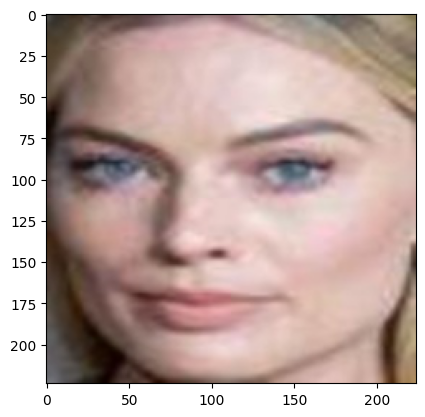

In [62]:
test_img =io.imread("C:/Users/asingh74/Desktop/DML_Projects/FACE/neg_case/Margot/Margot Robbie_44.jpg")
test_img=cv2.resize(test_img, (224, 224))
plt.imshow(test_img)
test_img = torch.from_numpy(test_img).permute (2, 0, 1)/255.0
model.load_state_dict(torch.load('Face_Model_Final.pt'))
model.eval ( )
with torch.no_grad():
    test_img = test_img.to(DEVICE)
    test_img_enc= model(test_img.unsqueeze (0))
    test_img_enc = test_img_enc.detach().cpu ().numpy ()
print(test_img_enc.shape)



In [63]:
anc_enc_arr = train_df.iloc[:,1:-1].to_numpy()
print(anc_enc_arr.shape)
print(test_img_enc.shape)

(909, 512)
(1, 512)


In [64]:
r = train_df.shape[0]

In [65]:
distance ={}
i=0
for i in range(r):
    dist=euclidean_dist(test_img_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1 

In [66]:
distance

{'Akshay Kumar_0.jpg': array([[1.32783271]]),
 'Akshay Kumar_1.jpg': array([[1.33702149]]),
 'Akshay Kumar_10.jpg': array([[1.33781868]]),
 'Akshay Kumar_11.jpg': array([[1.35972326]]),
 'Akshay Kumar_12.jpg': array([[1.34660273]]),
 'Akshay Kumar_13.jpg': array([[1.33951272]]),
 'Akshay Kumar_14.jpg': array([[1.36202028]]),
 'Akshay Kumar_15.jpg': array([[1.3120821]]),
 'Akshay Kumar_16.jpg': array([[1.35350737]]),
 'Akshay Kumar_17.jpg': array([[1.31781736]]),
 'Akshay Kumar_18.jpg': array([[1.32287127]]),
 'Akshay Kumar_19.jpg': array([[1.35176447]]),
 'Akshay Kumar_2.jpg': array([[1.33137276]]),
 'Akshay Kumar_20.jpg': array([[1.34531835]]),
 'Akshay Kumar_21.jpg': array([[1.30724209]]),
 'Akshay Kumar_22.jpg': array([[1.34887676]]),
 'Akshay Kumar_23.jpg': array([[1.34134251]]),
 'Akshay Kumar_24.jpg': array([[1.33527821]]),
 'Akshay Kumar_25.jpg': array([[1.33825155]]),
 'Akshay Kumar_26.jpg': array([[1.32046287]]),
 'Akshay Kumar_27.jpg': array([[1.32907948]]),
 'Akshay Kumar_28

In [67]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))

In [68]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Charlize Theron_23.jpg', 'Charlize Theron_25.jpg', 'Charlize Theron_26.jpg', 'Charlize Theron_3.jpg', 'Charlize Theron_22.jpg', 'Charlize Theron_29.jpg', 'Charlize Theron_15.jpg', 'Charlize Theron_27.jpg', 'Charlize Theron_21.jpg', 'Charlize Theron_19.jpg', 'Charlize Theron_1.jpg', 'Charlize Theron_12.jpg', 'Charlize Theron_20.jpg', 'Charlize Theron_11.jpg', 'Charlize Theron_8.jpg', 'Charlize Theron_2.jpg', 'Charlize Theron_0.jpg', 'Charlize Theron_7.jpg', 'Charlize Theron_14.jpg', 'Charlize Theron_13.jpg', 'Charlize Theron_6.jpg', 'Charlize Theron_28.jpg', 'Charlize Theron_4.jpg', 'Charlize Theron_9.jpg', 'Charlize Theron_24.jpg', 'Charlize Theron_10.jpg', 'Charlize Theron_16.jpg', 'Charlize Theron_17.jpg', 'Charlize Theron_5.jpg', 'Charlize Theron_18.jpg', 'Claire Holt_14.jpg', 'Claire Holt_7.jpg', 'Claire Holt_2.jpg', 'Claire Holt_1.jpg', 'Claire Holt_6.jpg', 'Claire Holt_17.jpg', 'Claire Holt_21.jpg', 'Claire Holt_24.jpg', 'Claire Holt_28.jpg', 'Claire Holt_27.jpg', 'Claire Holt_

## Plotting Five most similar Images

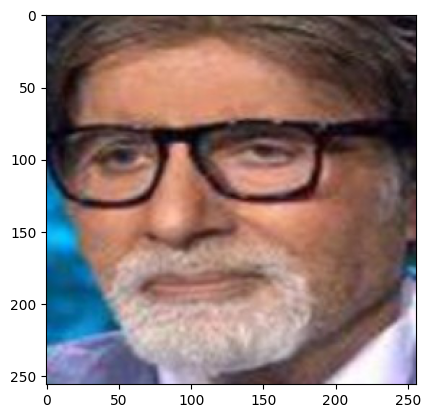

In [48]:
img_r = io.imread("C:/Users/asingh74/Desktop/DML_Projects/FACE/DataSet/Testing/Amitabh Bachchan/Amitabh Bachchan_47.jpg")
plt.imshow(img_r)

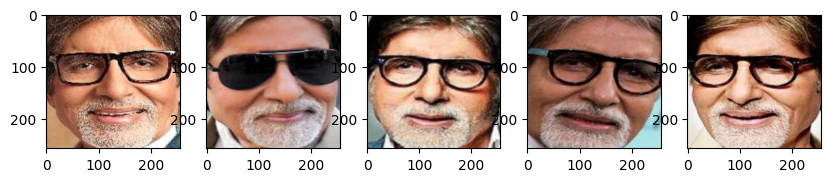

In [49]:
# Five nearest Images to img2

f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(10,5))
img1 = io.imread(DATA_DIR+dist_sort[1])
img2 = io.imread(DATA_DIR+dist_sort[2])
img3 = io.imread(DATA_DIR+dist_sort[3])
img4 = io.imread(DATA_DIR+dist_sort[4])
img5 = io.imread(DATA_DIR+dist_sort[5])
img_arr=[img1, img2,img3, img4, img5]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')
ax3.imshow(img3 , cmap='gray')
ax4.imshow(img4 , cmap='gray')
ax5.imshow(img5 , cmap='gray')

## Calculating Accuracy using silhouette_score

In [31]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# df_enc.drop(columns=['Faces'], inplace=True)
embeddings = df_enc.iloc[:,1:]
num_clusters = 31


kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(embeddings)


silhouette = silhouette_score(embeddings, labels)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.19079689850226347


C:\Users\asingh74\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [32]:
print("Accuracy of model is ", silhouette*100)

Accuracy of model is  19.079689850226348


## Calculating Accuracy for Validation data set

In [43]:
valid_df = valid_df.iloc[:,0]
valid_df = valid_df.to_frame()
valid_df = valid_df.drop_duplicates(subset=['Anchor'])
valid_df.shape

(98, 1)

In [44]:
valid_df=valid_df['Anchor'].tolist()

In [45]:
valid_df=pd.DataFrame(valid_df, columns=['Anchor'])

In [46]:
valid_df

Anchor
0     Priyanka Chopra_0.jpg
1     Priyanka Chopra_1.jpg
2    Priyanka Chopra_10.jpg
3    Priyanka Chopra_11.jpg
4    Priyanka Chopra_12.jpg
..                      ...
93  Robert Downey Jr_49.jpg
94   Robert Downey Jr_5.jpg
95   Robert Downey Jr_6.jpg
96   Robert Downey Jr_7.jpg
97   Robert Downey Jr_8.jpg

[98 rows x 1 columns]

In [47]:
model.load_state_dict(torch.load('Face_Model.pt'))
df_enc_valid=get_encoding_csv(model,valid_df['Anchor'])

  2%|█▋                                                                                 | 2/98 [00:00<00:06, 15.95it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 17%|██████████████▏                                                                   | 17/98 [00:00<00:01, 57.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 35%|████████████████████████████▍                                                     | 34/98 [00:00<00:00, 70.72it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 54%|████████████████████████████████████████████▎                                     | 53/98 [00:00<00:00, 79.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 71%|██████████████████████████████████████████████████████████▌                       | 70/98 [00:00<00:00, 79.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


 90%|█████████████████████████████████████████████████████████████████████████▋        | 88/98 [00:01<00:00, 81.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 73.68it/s]

A.unsqueeze (0) torch.Size([1, 3, 224, 224])
A.unsqueeze (0) torch.Size([1, 3, 224, 224])


In [48]:
df_enc_valid.to_csv("face_vectors_prepared_MobileNet_valid.csv", index=False)

In [49]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

df_enc_valid.drop(columns=['Anchor'], inplace=True)
embeddings = df_enc_valid.iloc[:,1:]
num_clusters = 31


kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(embeddings)


silhouette = silhouette_score(embeddings, labels)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.19827959


C:\Users\asingh74\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Taking Test Image

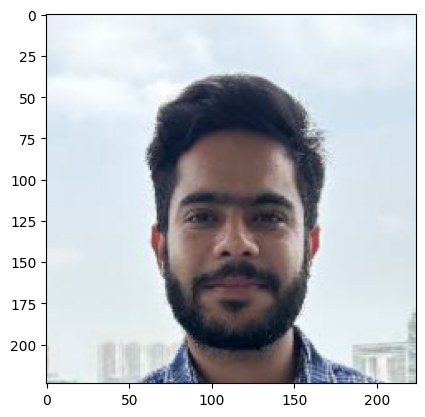

In [50]:
new_img =io.imread("C:/Users/asingh74/Desktop/Facial_Recognition_DML/Test_Image/Aryan_Test1.jpg")
new_img=cv2.resize(new_img, (224, 224))
plt.imshow(new_img)
new_img = torch.from_numpy(new_img).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    new_img = new_img.to(DEVICE)
    new_img_enc= model (new_img.unsqueeze (0))
    new_img_enc = new_img_enc.detach().cpu ().numpy ()
df = pd.DataFrame(new_img_enc)
df.to_csv("C:/Users/asingh74/Desktop/DML_Projects/Face/out.csv", index=False)

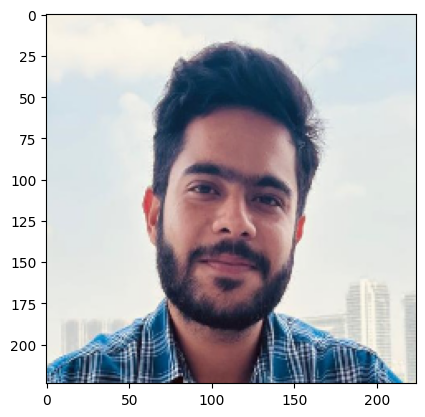

In [58]:
test_img =io.imread("C:/Users/asingh74/Desktop/Facial_Recognition_DML/Test_Image/Aryan_Test2.jpg")
test_img=cv2.resize(test_img, (224, 224))
plt.imshow(test_img)
test_img = torch.from_numpy(test_img).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    test_img = test_img.to(DEVICE)
    test_img_enc= model (test_img.unsqueeze (0))
    test_img_enc = test_img_enc.detach().cpu ().numpy ()
df = pd.DataFrame(test_img_enc)

In [59]:
distance ={}
for i in range(r):
    dist=euclidean_dist(test_img_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1 

In [60]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
print(sorted_dist)

{'Aryan.jpg': array([[1.02168467]]), 'Robert Downey Jr_23.jpg': array([[1.19062528]]), 'Robert Downey Jr_14.jpg': array([[1.26329004]]), 'Robert Downey Jr_44.jpg': array([[1.41178568]]), 'Robert Downey Jr_45.jpg': array([[1.42122204]]), 'Robert Downey Jr_41.jpg': array([[1.4214563]]), 'Priyanka Chopra_2.jpg': array([[1.43837024]]), 'Priyanka Chopra_4.jpg': array([[1.45245769]]), 'Robert Downey Jr_40.jpg': array([[1.45581203]]), 'Robert Downey Jr_22.jpg': array([[1.46573824]]), 'Priyanka Chopra_46.jpg': array([[1.50375923]]), 'Robert Downey Jr_5.jpg': array([[1.50545251]]), 'Priyanka Chopra_29.jpg': array([[1.50553716]]), 'Priyanka Chopra_15.jpg': array([[1.51479179]]), 'Priyanka Chopra_42.jpg': array([[1.5214942]]), 'Priyanka Chopra_48.jpg': array([[1.52181557]]), 'Robert Downey Jr_46.jpg': array([[1.52999217]]), 'Priyanka Chopra_40.jpg': array([[1.53172065]]), 'Robert Downey Jr_18.jpg': array([[1.54144975]]), 'Priyanka Chopra_24.jpg': array([[1.54313413]]), 'Priyanka Chopra_1.jpg': ar

In [61]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Aryan.jpg', 'Robert Downey Jr_23.jpg', 'Robert Downey Jr_14.jpg', 'Robert Downey Jr_44.jpg', 'Robert Downey Jr_45.jpg', 'Robert Downey Jr_41.jpg', 'Priyanka Chopra_2.jpg', 'Priyanka Chopra_4.jpg', 'Robert Downey Jr_40.jpg', 'Robert Downey Jr_22.jpg', 'Priyanka Chopra_46.jpg', 'Robert Downey Jr_5.jpg', 'Priyanka Chopra_29.jpg', 'Priyanka Chopra_15.jpg', 'Priyanka Chopra_42.jpg', 'Priyanka Chopra_48.jpg', 'Robert Downey Jr_46.jpg', 'Priyanka Chopra_40.jpg', 'Robert Downey Jr_18.jpg', 'Priyanka Chopra_24.jpg', 'Priyanka Chopra_1.jpg', 'Priyanka Chopra_34.jpg', 'Priyanka Chopra_43.jpg', 'Robert Downey Jr_6.jpg', 'Robert Downey Jr_32.jpg', 'Robert Downey Jr_39.jpg', 'Robert Downey Jr_21.jpg', 'Robert Downey Jr_15.jpg', 'Robert Downey Jr_31.jpg', 'Robert Downey Jr_16.jpg', 'Robert Downey Jr_49.jpg', 'Priyanka Chopra_12.jpg', 'Priyanka Chopra_20.jpg', 'Priyanka Chopra_3.jpg', 'Robert Downey Jr_7.jpg', 'Priyanka Chopra_7.jpg', 'Robert Downey Jr_13.jpg', 'Robert Downey Jr_42.jpg', 'Robert Dow

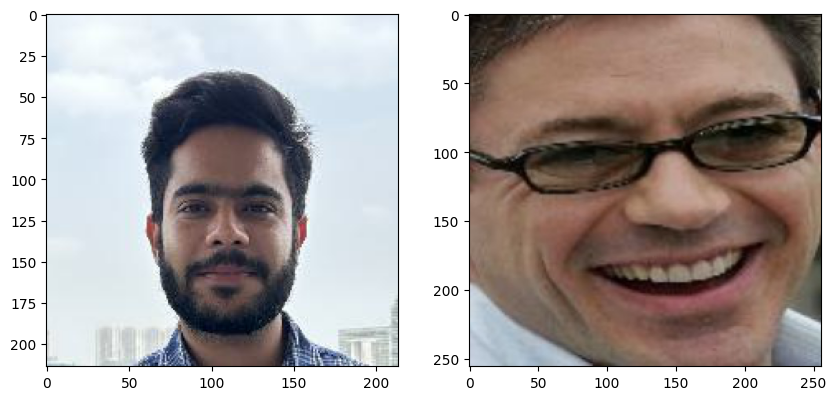

In [62]:
# Two nearest Images to img2
f, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
img1 = io.imread("C:/Users/asingh74/Desktop/Facial_Recognition_DML/Test_Image/Aryan_Test1.jpg")
img2 = io.imread(DATA_DIR+dist_sort[1])
img_arr=[img1, img2]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')

(1, 512)


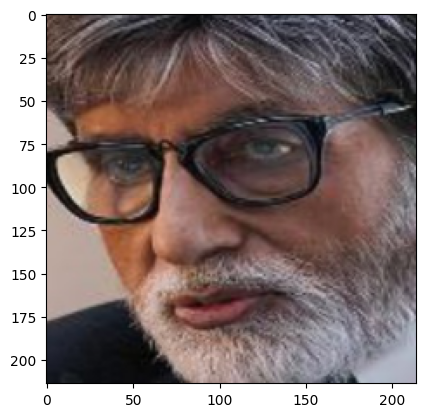

In [165]:
new_img =io.imread("C:/Users/asingh74/Desktop/Facial_Recognition_DML/Faces/Amitabh Bachchan_0.jpg")
new_img=cv2.resize(new_img, (214, 214))
img = torch.from_numpy(new_img).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc= model (img.unsqueeze (0))
    img_enc = img_enc.detach().cpu ().numpy ()
print(img_enc.shape)
plt.imshow(new_img)

In [166]:
distance ={}
for i in range(r):
    dist=euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1    

In [167]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
print(sorted_dist)

{'Amitabh Bachchan_0.jpg': array([[0.07741315]]), 'Amitabh Bachchan_45.jpg': array([[0.08959618]]), 'Amitabh Bachchan_39.jpg': array([[0.09097749]]), 'Amitabh Bachchan_1.jpg': array([[0.09123788]]), 'Amitabh Bachchan_34.jpg': array([[0.09275418]]), 'Amitabh Bachchan_23.jpg': array([[0.09565255]]), 'Amitabh Bachchan_30.jpg': array([[0.09904808]]), 'Amitabh Bachchan_47.jpg': array([[0.10205064]]), 'Amitabh Bachchan_9.jpg': array([[0.10418643]]), 'Amitabh Bachchan_40.jpg': array([[0.10468629]]), 'Amitabh Bachchan_8.jpg': array([[0.10539234]]), 'Amitabh Bachchan_21.jpg': array([[0.10722201]]), 'Amitabh Bachchan_46.jpg': array([[0.11035843]]), 'Amitabh Bachchan_12.jpg': array([[0.11045216]]), 'Amitabh Bachchan_14.jpg': array([[0.11066712]]), 'Amitabh Bachchan_22.jpg': array([[0.11105271]]), 'Amitabh Bachchan_4.jpg': array([[0.11223595]]), 'Amitabh Bachchan_48.jpg': array([[0.1124208]]), 'Amitabh Bachchan_44.jpg': array([[0.11305696]]), 'Amitabh Bachchan_7.jpg': array([[0.11346171]]), 'Amita

In [168]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Amitabh Bachchan_0.jpg', 'Amitabh Bachchan_45.jpg', 'Amitabh Bachchan_39.jpg', 'Amitabh Bachchan_1.jpg', 'Amitabh Bachchan_34.jpg', 'Amitabh Bachchan_23.jpg', 'Amitabh Bachchan_30.jpg', 'Amitabh Bachchan_47.jpg', 'Amitabh Bachchan_9.jpg', 'Amitabh Bachchan_40.jpg', 'Amitabh Bachchan_8.jpg', 'Amitabh Bachchan_21.jpg', 'Amitabh Bachchan_46.jpg', 'Amitabh Bachchan_12.jpg', 'Amitabh Bachchan_14.jpg', 'Amitabh Bachchan_22.jpg', 'Amitabh Bachchan_4.jpg', 'Amitabh Bachchan_48.jpg', 'Amitabh Bachchan_44.jpg', 'Amitabh Bachchan_7.jpg', 'Amitabh Bachchan_6.jpg', 'Amitabh Bachchan_17.jpg', 'Amitabh Bachchan_16.jpg', 'Amitabh Bachchan_18.jpg', 'Amitabh Bachchan_41.jpg', 'Amitabh Bachchan_42.jpg', 'Amitabh Bachchan_3.jpg', 'Amitabh Bachchan_2.jpg', 'Amitabh Bachchan_38.jpg', 'Amitabh Bachchan_19.jpg', 'Amitabh Bachchan_25.jpg', 'Amitabh Bachchan_37.jpg', 'Amitabh Bachchan_20.jpg', 'Amitabh Bachchan_43.jpg', 'Amitabh Bachchan_11.jpg', 'Amitabh Bachchan_36.jpg', 'Amitabh Bachchan_35.jpg', 'Amitabh 

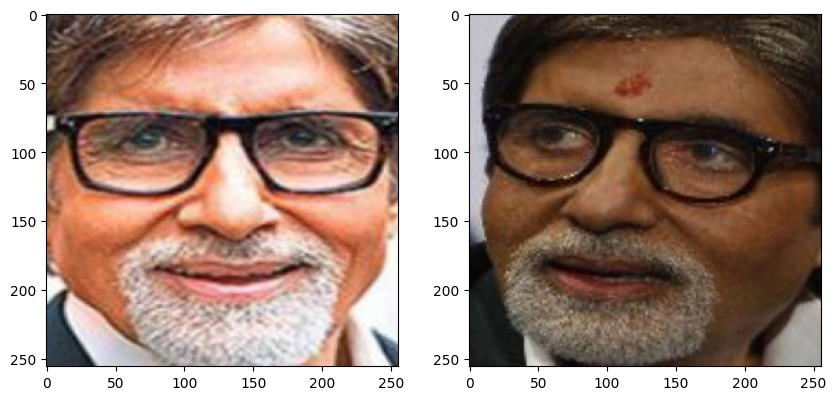

In [169]:
# Two nearest Images to img2
f, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
img1 = io.imread(DATA_DIR+dist_sort[1])
img2 = io.imread(DATA_DIR+dist_sort[2])
img_arr=[img1, img2, img3, img4, img5]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')

## Taking One more face

(1, 512)


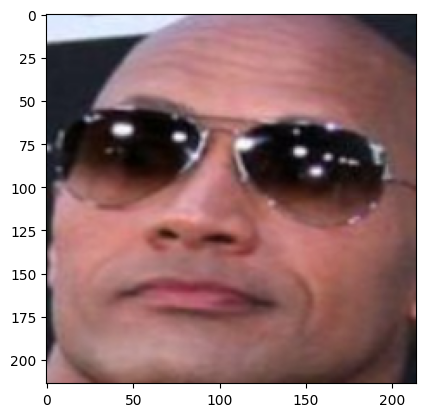

In [170]:
new_img =io.imread("C:/Users/asingh74/Desktop/Facial_Recognition_DML/Faces/Dwayne Johnson_38.jpg")
new_img=cv2.resize(new_img, (214, 214))
img = torch.from_numpy(new_img).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc= model (img.unsqueeze (0))
    img_enc = img_enc.detach().cpu ().numpy ()
print(img_enc.shape)
plt.imshow(new_img)

In [171]:
distance ={}
for i in range(r):
    dist=euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1 

In [172]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
print(sorted_dist)

{'Dwayne Johnson_38.jpg': array([[0.04961683]]), 'Dwayne Johnson_35.jpg': array([[0.0986311]]), 'Dwayne Johnson_37.jpg': array([[0.10559357]]), 'Dwayne Johnson_16.jpg': array([[0.10613183]]), 'Dwayne Johnson_7.jpg': array([[0.10716738]]), 'Dwayne Johnson_42.jpg': array([[0.10817666]]), 'Dwayne Johnson_22.jpg': array([[0.10868581]]), 'Dwayne Johnson_3.jpg': array([[0.11184297]]), 'Dwayne Johnson_47.jpg': array([[0.11186348]]), 'Dwayne Johnson_11.jpg': array([[0.11575848]]), 'Dwayne Johnson_17.jpg': array([[0.1162683]]), 'Dwayne Johnson_6.jpg': array([[0.116923]]), 'Dwayne Johnson_9.jpg': array([[0.11901322]]), 'Dwayne Johnson_34.jpg': array([[0.11931221]]), 'Dwayne Johnson_12.jpg': array([[0.12038297]]), 'Dwayne Johnson_8.jpg': array([[0.12212486]]), 'Dwayne Johnson_39.jpg': array([[0.1223892]]), 'Dwayne Johnson_31.jpg': array([[0.12240927]]), 'Dwayne Johnson_36.jpg': array([[0.12278472]]), 'Dwayne Johnson_13.jpg': array([[0.12414429]]), 'Dwayne Johnson_25.jpg': array([[0.12571281]]), '

In [173]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Dwayne Johnson_38.jpg', 'Dwayne Johnson_35.jpg', 'Dwayne Johnson_37.jpg', 'Dwayne Johnson_16.jpg', 'Dwayne Johnson_7.jpg', 'Dwayne Johnson_42.jpg', 'Dwayne Johnson_22.jpg', 'Dwayne Johnson_3.jpg', 'Dwayne Johnson_47.jpg', 'Dwayne Johnson_11.jpg', 'Dwayne Johnson_17.jpg', 'Dwayne Johnson_6.jpg', 'Dwayne Johnson_9.jpg', 'Dwayne Johnson_34.jpg', 'Dwayne Johnson_12.jpg', 'Dwayne Johnson_8.jpg', 'Dwayne Johnson_39.jpg', 'Dwayne Johnson_31.jpg', 'Dwayne Johnson_36.jpg', 'Dwayne Johnson_13.jpg', 'Dwayne Johnson_25.jpg', 'Dwayne Johnson_49.jpg', 'Dwayne Johnson_43.jpg', 'Dwayne Johnson_41.jpg', 'Dwayne Johnson_4.jpg', 'Dwayne Johnson_24.jpg', 'Dwayne Johnson_2.jpg', 'Dwayne Johnson_18.jpg', 'Dwayne Johnson_27.jpg', 'Dwayne Johnson_10.jpg', 'Dwayne Johnson_19.jpg', 'Dwayne Johnson_14.jpg', 'Dwayne Johnson_0.jpg', 'Dwayne Johnson_48.jpg', 'Dwayne Johnson_33.jpg', 'Dwayne Johnson_20.jpg', 'Dwayne Johnson_21.jpg', 'Dwayne Johnson_5.jpg', 'Dwayne Johnson_32.jpg', 'Dwayne Johnson_15.jpg', 'Dwayne 

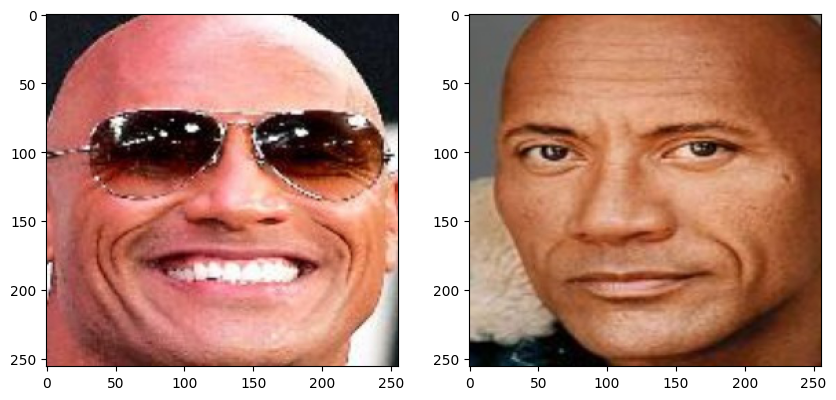

In [174]:
# Two nearest Images to img2
f, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
img1 = io.imread(DATA_DIR+dist_sort[1])
img2 = io.imread(DATA_DIR+dist_sort[2])
img_arr=[img1, img2, img3, img4, img5]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')

## Another Way of calculating Accuracy

In [175]:
from sklearn.model_selection import train_test_split

In [176]:
train_df, temp_df = train_test_split(df_enc, test_size=0.4, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [177]:
def process_row(row):
    value = row['Faces']
    x=value.split('_')
    new_value = x[0]
    return new_value

In [178]:
train_df['Labels'] = train_df.apply(process_row, axis=1)
valid_df['Labels'] = valid_df.apply(process_row, axis=1)

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [180]:
x_train=train_df.iloc[1:,1:513]
y_train=train_df.iloc[1:, 513]

In [181]:
x_test=valid_df.iloc[1:,1:513]
y_test=valid_df.iloc[1:,513]

In [182]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [183]:
model = RandomForestClassifier()  
model.fit(x_train, y_train_encoded)

RandomForestClassifier()

In [184]:
y_pred = model.predict(x_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy*100)

Accuracy: 100.0
